## https://blog.gbrueckl.at/2024/04/visualizing-spark-execution-plans/

In [ ]:
#!sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#!apt install graphviz
#!apt install xdg-utils
#!pip install graphviz

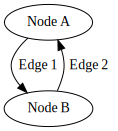

Done.


In [1]:
# simple test example
import graphviz

dot = graphviz.Digraph()
dot.node('A', 'Node A', tooltip="hello A") # no tooltips in jupyter...
dot.node('B', 'Node B')
dot.edge('A', 'B', 'Edge 1')
dot.edge('B', 'A', 'Edge 2')
graphviz.set_jupyter_format("svg")
display(dot)
print("Done.")

In [2]:
from pyspark.sql import DataFrame
import re, contextlib, io, math
from graphviz import Digraph

print("Loading VisualizeExecutionPlan library ...")


def get_execution_plan(df: DataFrame) -> str:
    with contextlib.redirect_stdout(io.StringIO()) as stdout:
        df.explain(mode="cost")

    plan = stdout.getvalue()
    return plan


class PlanNode:
    plan_type: str
    level: int
    line: str
    line_number: int
    parent: any
    identifier: str
    table: str
    operation: str
    sub_operation: str
    
    size_in_bytes: int
    size: str

    node_type: str
    node_label: str
    node_tooltip: str

    edge_label: str
    edge_tooltip: str

    node_matching_text: str

    def __init__(self, line, line_number, plan_type):
        if line.startswith("*"): # replace whole-stage code gen prefix
            line = re.sub('([^*]*)\*\([0-9]*\)\s(.*)', r'\1\2', line)

        self.line = line
        self.line_number = line_number
        self.plan_type = plan_type

        self.level = self.get_level()

        self.parent = None

        self.populate_fields()

    def populate_fields(self):
        
        self.text = self.get_text()
        
        self.identifier = self.get_identifier()
        self.table = self.get_table()
        self.operation = self.get_operation()
        self.sub_operation = self.get_sub_operation()
        self.size_in_bytes = self.get_size_in_bytes()
        self.size = self.get_size()
        self.node_type = self.get_node_type()
        self.node_label = self.get_node_label()
        self.node_tooltip = self.get_node_tooltip()
        self.edge_label = self.get_edge_label()
        self.edge_tooltip = self.get_edge_tooltip()

        self.node_matching_text = self.get_node_matching_text()

    def get_level(self) -> int:
        return int(re.search(r'[A-Z]', self.line).start() / 3)

    def get_parent(self, skip_ops: list[str] = []):
        if not self.parent:
            return None

        it = self.parent
        while it.get_operation() in skip_ops:
            it = it.parent

        return it

    def get_identifier(self):
        return str(self.line_number)

    def get_operation(self) -> str:
        #m = re.search('^[:\s+-]*(.*?)[\(),\s]', self.line)
        m = re.search('([A-Za-z]+)', self.line)
        if m:
            return m.group(1)
        else:
            return self.line

    def get_sub_operation(self) -> str:
        m = re.search('^[:\s+-]*([A-Za-z]+)\s([A-Za-z]+)', self.line)
        if m:
            if m.group(1) in ["Join", "FileScan"]:
                return m.group(2)
            return m.group(1)
        else:
            return self.get_operation()

    def get_table(self) -> str:
        m = re.search('([a-z0-9-_]*)\.([a-z0-9-_]*)\.([a-z0-9-_]*)', self.line)
        if m:
            #return f"{m.group(1)}.{m.group(2)}.{m.group(3)}"
            return f"{m.group(2)}.{m.group(3)}"
        else:
            return None

    def get_size_in_bytes(self) -> int:
        # from https://semyonsinchenko.github.io/ssinchenko/post/estimation-spark-df-size/
        m = re.search('sizeInBytes\s*=\s*([0-9.]*)\s(.*?)[),]', self.line)
        if m:
            size = float(m.group(1))
            units = m.group(2)
        else:
            return -1

        units = units.replace("i", "")

        size_names = ["B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB"]
        i = size_names.index(units)
        p = math.pow(1024, i)
        
        size = size * p

        return size  # size in byte

    def get_size(self) -> str:
        size_bytes = self.get_size_in_bytes()
        if size_bytes == -1:
            return None

        if size_bytes == 0:
            return "0B"

        size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
        i = int(math.floor(math.log(size_bytes, 1024)))
        p = math.pow(1024, i)
        s = round(size_bytes / p, 2)
        return "%s %s" % (s, size_name[i])

    def get_node_type(self) -> str:
        if self.table:
            return "table"
        else:
            if "Join" in self.operation:
                return "join"
            return self.operation.lower()

    def get_node_label(self) -> str:
        if not self.parent:
            return f"RESULT"
        if self.node_type == "table":
            return self.get_table()

        ret = self.operation
        if self.node_type == "join":
            if self.plan_type == "logical":
                ret += "\n" + self.sub_operation
            elif self.plan_type == "physical":
                ret += "\n" + self.text.split(",")[-3]

        return ret

    def get_node_tooltip(self) -> str:
        return self.text

    def get_edge_label(self) -> str:
        return self.get_size()

    def get_edge_tooltip(self) -> str:
        return None

    def get_text(self) -> str:
        m = re.search('^[:\s+-]*(.*)', self.line)
        return m.group(1)

    def get_node_matching_text(self) -> str:
        if self.node_type == "table":
            return self.table
        if self.operation == "Filter":
            return self.text.split(',')[0]

    def to_string(self):
        print(f'parent id: {None if self.parent is None else self.parent.identifier}')
        print(f'plan_type: {self.plan_type}')
        print(f'level: {self.level}')
        print(f'line: {self.line}')
        print(f'line_number: {self.line_number}')
        print(f'identifier: {self.identifier}')
        print(f'table: {self.table}')
        print(f'operation: {self.operation}')
        print(f'sub_operation: {self.sub_operation}')
        print(f'size_in_bytes: {self.size_in_bytes}')
        print(f'size: {self.size}')
        print(f'node_type: {self.node_type}')
        print(f'node_label: {self.node_label}')
        print(f'node_tooltip: {self.node_tooltip}')
        print(f'edge_label: {self.edge_label}')
        print(f'edge_tooltip: {self.edge_tooltip}')
        print(f'node_matching_text: {self.node_matching_text}')


def execution_plan_to_nodes(exec_plan: str, plan_type: str = "combined") -> list[PlanNode]:
    assert plan_type in ["logical", "physical", "combined"]
    
    if plan_type == "combined":
        logical_nodes = execution_plan_to_nodes(exec_plan, "logical")
        physical_nodes = execution_plan_to_nodes(exec_plan, "physical")

        for node in physical_nodes:
            log_node = next((nd for nd in logical_nodes if nd.node_matching_text == node.node_matching_text), None)
            if log_node:
                node.size = log_node.size
                node.size_in_bytes = log_node.size_in_bytes
                node.edge_label = log_node.edge_label
                node.edge_tooltip = log_node.edge_tooltip

        return physical_nodes

    lines = [l for l in exec_plan.split("\n") if len(l.strip()) > 0]

    nodes = []
    line_number = 1
    capture_started = False
    for line in lines:          
        node = PlanNode(line, line_number, plan_type)
        line_number += 1

        if line.startswith("==") and line.endswith("=="):
            if not capture_started: 
                if plan_type == "logical":
                    if "== Optimized Logical Plan ==" in line:
                        capture_started = True
                        node.line = "RESULT"
                        node.level = -1
                elif plan_type == "physical":
                    if line == "== Physical Plan ==":
                        capture_started = True
                        node.line = "RESULT"
                        node.level = -1
                else:
                    raise Exception("Invalid plan_type! Only 'logical' and 'physical' are supported!")
            else:
                break

        if not capture_started:
            continue
        
        parent = next((nd for nd in reversed(nodes) if nd.level == node.level - 1), None)
        node.parent = parent
        node.populate_fields()

        nodes.append(node)

    return nodes

############################################################
# https://graphviz.readthedocs.io/en/stable/examples.html
############################################################
def get_graph_from_nodes(nodes: list[PlanNode], skip_operations: list[str] = []):
    g = Digraph(name="Execution Plan", comment='Execution Plan')

    g.attr(label=r'Execution Plan\nSizes are estimates based on table statistics\nThey are not reliable anymore after joins are involved!')
    g.attr(fontsize='12')

    g.attr('node', shape='box3d')
    g.attr('node', color='black')

    for node in nodes:
        if node.operation in skip_operations:
            continue

        if node.node_type == "table":
            color = 'lightgreen'
        elif node.node_type == "join":
            color = 'lightblue'
        else:
            color = 'white'

        g.node(node.identifier, node.get_node_label(), style='filled', fillcolor=color, tooltip=node.node_tooltip)

        if node.get_parent(skip_operations):
            g.edge(node.identifier, node.get_parent(skip_operations).identifier, node.edge_label, tooltip=node.edge_tooltip )

    return g


def get_plan_viz(df: DataFrame, skip_operations: list[str] = [], debug: bool=False):
    exec_plan = get_execution_plan(df)
    nodes = execution_plan_to_nodes(exec_plan)

    if debug:
        for n in nodes:
            print("******")
            n.to_string()
    
    plan_viz = get_graph_from_nodes(nodes, skip_operations)

    return plan_viz


def show_plan(df: DataFrame, skip_operations: list[str] = [], debug: bool=False):
    display(get_plan_viz(df, skip_operations, debug))


print("Done.")

Loading VisualizeExecutionPlan library ...
Done.


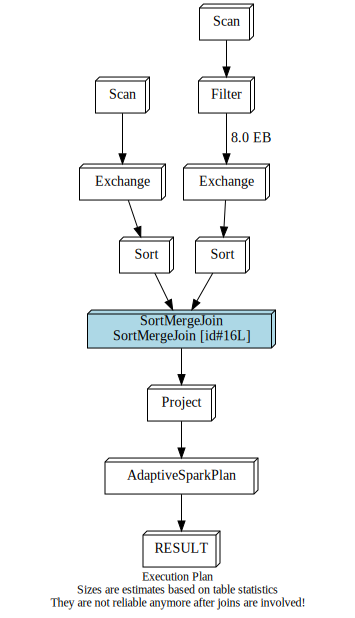

Done.


In [3]:
from pyspark.sql import *

spark = (SparkSession.builder
         #.master("local")
         .appName("Shuffle perf test with unordered vs ordered join keys")
         .enableHiveSupport() # enableHiveSupport() needed to make data persistent...
         .config("spark.log.level", "ERROR")
         .config("spark.executor.memory", "1g")
         .config("spark.driver.memory", "1g")
         .getOrCreate())
		 
lst1 = [
    (
	  c1,
      'name1'
     )
    for c1 in range(10)]
df1 = spark.createDataFrame(lst1, ['id', 'name'])

lst2 = [
    (
	  c1,
      'name2'
     )
    for c1 in range(10)]
df2 = spark.createDataFrame(lst2, ['id', 'name'])

df = df1.alias('df1').join(df2.alias('df2'), 'id', 'left').select(df1.id, df1.name.alias('name1'), df2.name.alias('name2'))

#print(get_execution_plan(df))
show_plan(df, debug=False)
print("Done.")

In [5]:
# create 2 REAL tables for the plan
spark.sql('use mytestdb')
spark.sql('show tables').show()
spark.sql('CREATE TABLE IF NOT EXISTS df1(id int, name varchar(50))')
spark.sql('INSERT INTO df1 VALUES(1,"Aname1")')
spark.sql('CREATE TABLE IF NOT EXISTS df2(id int, name varchar(50))')
spark.sql('INSERT INTO df2 VALUES(1,"Bname1")')

++
||
++
++

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
| mytestdb|                 df1|      false|
| mytestdb|                 df2|      false|
| mytestdb|t_my_date_partiti...|      false|
| mytestdb|v_my_date_partiti...|      false|
+---------+--------------------+-----------+



DataFrame[]

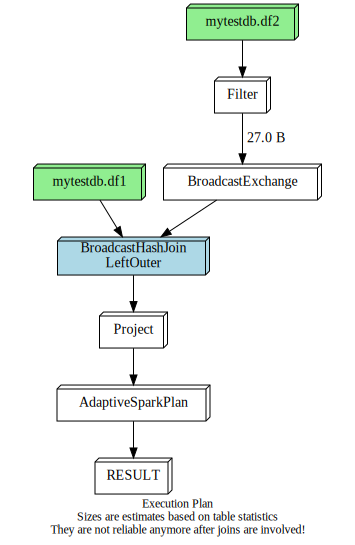

In [4]:
spark.sql('use mytestdb')
df=spark.sql('SELECT df1.id, df1.name as name1, df2.name as name2 FROM df1 left outer join df2 on (df1.id = df2.id)')
show_plan(df)

In [5]:
spark.stop()
print("Done.")

Done.
